# Find best parameters describing data, both combined and separated fits. 


In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
from scipy.optimize import curve_fit
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.stats as stats
import pandas as pd
from importlib import reload
from scipy.interpolate import interp1d,interp2d

import os
cwd=os.getcwd()

area=4.0;linethicknes=1.0;

font = {'family' : 'normal','weight' : 'normal','size'   : 7, 'family':'serif','serif':['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] =linethicknes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42
area=4.0;linethicknes=1.0;


########################################################################
############# Import code

sys.path.insert(0, './../../../DataAndScripts/unstructured_scripts/')
import functions_optimal as fun
import sims_utils as su
import functions_dynamics as fun_dyna

# Load results file
This file is the outcome of hundreds of thousands of simulations run in the cluster

In [2]:

path2results=cwd+'/../../../DataAndScripts/unstructured_scripts/simulation_results/'
results, jn = su.get_concatenated_results(path2results)

    

Your results files are of the form: results
Found 5 results files
Last loaded file number: 4


In [3]:
sim_param_all=results[:,0:15]
moments_of_r_sim_all=results[:,15:20]

sim_g_E=(sim_param_all[:,2])
sim_g_I=(sim_param_all[:,3])
sim_beta=(sim_param_all[:,4])
sim_CV_K=(sim_param_all[:,7])
sim_sigma_Lambda_over_Lambda=(sim_param_all[:,10])
sim_J=(sim_param_all[:,11])
sim_r_X=(sim_param_all[:,12])
sim_ell=(sim_param_all[:,13])

print(np.shape(results))
#(121278, 28)


param_min=np.asarray([np.min(sim_g_E),np.min(sim_g_I),np.min(np.log10(sim_beta)),
                      np.min(np.log10(sim_CV_K)),np.min(np.log10(sim_sigma_Lambda_over_Lambda)),np.min(np.log10(sim_J)),])
param_max=np.asarray([np.max(sim_g_E),np.max(sim_g_I),np.max(np.log10(sim_beta)),
                      np.max(np.log10(sim_CV_K)),np.max(np.log10(sim_sigma_Lambda_over_Lambda)),np.max(np.log10(sim_J)),])
    


(770195, 28)


# Load recordings in mice and monkeys

In [4]:

#######################################
folder_data='./../../../DataAndScripts/experimental_data/'
#######################################

data_monkeys=np.loadtxt(folder_data+'Monkeys_with_trials.txt');
data_mice=np.loadtxt(folder_data+'Mice_with_trials.txt');

data_both_species=[data_mice,data_monkeys]
species=['Mice','Monkeys']

dataset_both_species,Con_both_species,nCon_both_species,normalization_both_species=[],[],[],[]
for idx_species in range(2):
    dataset,Con,nCon=fun.build_dataset(data_both_species[idx_species])
    normalization=1.0;#np.mean(dataset[0,:,0])
    dataset_both_species=dataset_both_species+[dataset]
    Con_both_species=Con_both_species+[Con]
    nCon_both_species=nCon_both_species+[nCon]
    normalization_both_species=normalization_both_species+[normalization]


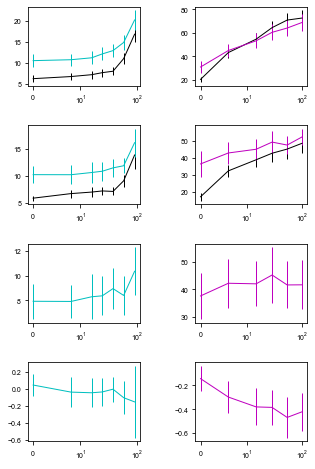

In [5]:

rows=4
cols=2

colors=['c','m']
fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.ravel()



for idx_species in range(2):
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]

    for idx_moment in range(6):
        if idx_moment<2:
            idx_row=0
            ccc=['k',colors[idx_species]][idx_moment]
            
        if (idx_moment>=2)&(idx_moment<4):
            idx_row=1
            ccc=['k',colors[idx_species]][idx_moment-2]

        if (idx_moment==4):
            idx_row=2
            ccc=colors[idx_species]

        if (idx_moment==5):
            idx_row=3
            ccc=colors[idx_species]
            
        axs[2*idx_row+idx_species].errorbar(Con,dataset[idx_moment,:,0],dataset[idx_moment,:,1],
                                                 color=ccc,)

        axs[2*idx_row+idx_species].set_xscale('symlog', linthreshx=12)




# Train DNN

In [6]:
Predictor_sim, Predictor_data=fun.build_function(results[:200,:])

Test R^2 Score : 0.350
Training R^2 Score : 0.830


# HERE we should run this for ALL results (not only 200, save this and then call it back in the other notebook)

# Fit a model to each species separately


In this part, we fit the model multiple times, with different initial conditions, compute the error and store it, then we have an ensamble of fits and choose the best


In [11]:

nRep=10;
ALL_sol,ALL_cost=[],[]
for idx_species in range(2):
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]
    sol,cost=fun.fit_model_to_data(dataset,Predictor_data,nCon,nRep)
    
    ALL_sol=ALL_sol+[sol]
    ALL_cost=ALL_cost+[cost]


100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


# Plot the best fit prediction 

Mice 1.0383880914198054
array([ 8.01,  5.25, -0.29, -2.23, -0.56, -3.8 ])
array([0.58, 0.61, 0.63, 0.65, 0.67, 0.76, 0.94, 0.96])
Monkeys 16.864787912098613
array([10.  ,  4.59, -0.06, -3.52,  0.52, -2.4 ])
array([0.59, 1.27, 1.62, 1.88, 1.97, 2.  , 0.89])


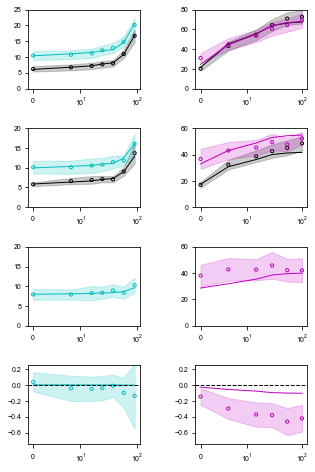

In [8]:

rows=4
cols=2

colors=['c','m']
fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.ravel()



for idx_species in range(2):
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]
    
    sol=ALL_sol[idx_species]
    cost=ALL_cost[idx_species]
    idx_best=np.argmin(cost)
    best_param=sol[idx_best,:]
    best_cost=cost[idx_best]
    best_inputs=fun.fit_inputs_to_data_given_param(dataset,Predictor_data,best_param,nCon)
    
    Predictions=Predictor_data(best_inputs,best_param,nCon)
    print(['Mice','Monkeys'][idx_species],best_cost)
    print(repr(best_param))
    print(repr(best_inputs))        
    for idx_moment in range(6):
        if idx_moment<2:
            idx_row=0
            ccc=['k',colors[idx_species]][idx_moment]
            ymin=0
            ymax=[25,80][idx_species]
            
        if (idx_moment>=2)&(idx_moment<4):
            idx_row=1
            ccc=['k',colors[idx_species]][idx_moment-2]
            ymin=0
            ymax=[20,60][idx_species]
         
        if (idx_moment==4):
            idx_row=2
            ccc=colors[idx_species]
            ymin=0
            ymax=[20,60][idx_species]
         
        if (idx_moment==5):
            idx_row=3
            ccc=colors[idx_species]
            ymin=-0.75
            ymax=0.25
                     
        m,sem=dataset[idx_moment,:,0],dataset[idx_moment,:,1]
        axs[2*idx_row+idx_species].scatter(Con,m,
                                           facecolors='none', s=10,edgecolors=ccc,marker='o'
                                           )
        axs[2*idx_row+idx_species].fill_between(Con,m-sem,m+sem,
                                                 color=ccc,alpha=0.2)
    
        axs[2*idx_row+idx_species].plot(Con,Predictions[idx_moment,:],
                                        color=ccc,alpha=1.)

        axs[2*idx_row+idx_species].set_xscale('symlog', linthreshx=12)
        axs[2*idx_row+idx_species].set_ylim([ymin,ymax])
    axs[2*idx_row+idx_species].axhline(y=0,ls='--',c='k')

# Now we fit the same model to both species. 
 In this case the input will then be the combined data for both species

In [9]:
reload(fun)
nRep=20;

DATA_both_species=[dataset_both_species,Con_both_species,nCon_both_species,normalization_both_species]
CMB_sol,CMB_cost=fun.fit_model_to_data_both_species(DATA_both_species,Predictor_data,nCon,nRep)


100%|██████████| 20/20 [03:21<00:00, 10.09s/it]


# Plot the best fit prediction in this case

Mice 29.356019932149913
array([ 4.8 ,  5.01, -0.62, -1.04,  0.68, -3.9 ])
array([0.78, 0.8 , 0.81, 0.83, 0.84, 0.92, 1.1 , 0.1 ])
Monkeys 29.356019932149913
array([ 4.8 ,  5.01, -0.62, -1.04,  0.68, -3.9 ])
array([1.16, 1.6 , 1.78, 1.9 , 1.95, 2.  , 0.73])


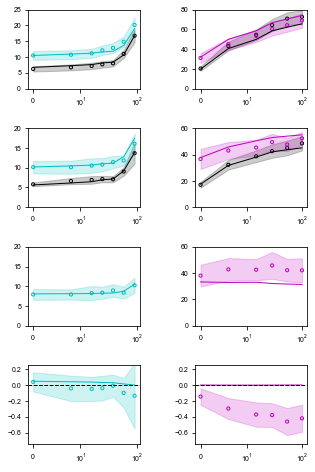

In [10]:

rows=4
cols=2

colors=['c','m']
fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
axs = axs.ravel()



for idx_species in range(2):
    dataset=dataset_both_species[idx_species]
    Con=Con_both_species[idx_species]
    nCon=nCon_both_species[idx_species]
    normalization=normalization_both_species[idx_species] 

    idx_best=np.argsort(CMB_cost)[0]
    best_param=CMB_sol[idx_best,:]
    best_cost=CMB_cost[idx_best]
    best_inputs=fun.fit_inputs_to_data_given_param(dataset,Predictor_data,best_param,nCon)

    
    Predictions=Predictor_data(best_inputs,best_param,nCon)
    print(['Mice','Monkeys'][idx_species],best_cost)
    print(repr(best_param))
    print(repr(best_inputs))        
    for idx_moment in range(6):
        if idx_moment<2:
            idx_row=0
            ccc=['k',colors[idx_species]][idx_moment]
            ymin=0
            ymax=[25,80][idx_species]
            
        if (idx_moment>=2)&(idx_moment<4):
            idx_row=1
            ccc=['k',colors[idx_species]][idx_moment-2]
            ymin=0
            ymax=[20,60][idx_species]
         
        if (idx_moment==4):
            idx_row=2
            ccc=colors[idx_species]
            ymin=0
            ymax=[20,60][idx_species]
         
        if (idx_moment==5):
            idx_row=3
            ccc=colors[idx_species]
            ymin=-0.75
            ymax=0.25
                     
        m,sem=dataset[idx_moment,:,0],dataset[idx_moment,:,1]
        axs[2*idx_row+idx_species].scatter(Con,m,
                                           facecolors='none', s=10,edgecolors=ccc,marker='o'
                                           )
        axs[2*idx_row+idx_species].fill_between(Con,m-sem,m+sem,
                                                 color=ccc,alpha=0.2)
    
        axs[2*idx_row+idx_species].plot(Con,Predictions[idx_moment,:],
                                        color=ccc,alpha=1.)

        axs[2*idx_row+idx_species].set_xscale('symlog', linthreshx=12)
        axs[2*idx_row+idx_species].set_ylim([ymin,ymax])
    axs[2*idx_row+idx_species].axhline(y=0,ls='--',c='k')

# Add fits to each species separately to a the file containing all the possible fits  

In [11]:
Tmax_over_tau_E=2*10**2
n_rep=20;
sigma_t=0.01; 
tau_rp=0.002; 


In [12]:
count=0;
for idx_rep in range(n_rep):
    for idx_combined in range(2):
        for idx_species in range(2):
            dataset=dataset_both_species[idx_species]
            Con=Con_both_species[idx_species]
            nCon=nCon_both_species[idx_species]
            normalization=normalization_both_species[idx_species] 
            if idx_combined==0:
                # best fit combined
                sol=ALL_sol[idx_species]
                cost=ALL_cost[idx_species]
                idx_best=np.argmin(cost)
                best_param=sol[idx_best,:]
            if idx_combined==1:
                # best fit in mice or monkeys
                idx_best=np.argmin(CMB_cost)
                best_param=CMB_sol[idx_best,:]
                best_cost=CMB_cost[idx_best]


            best_inputs=fun.fit_inputs_to_data_given_param(dataset,Predictor_data,best_param,nCon)

            Possible_r_X=10**best_inputs[0:-1]
            ell=10**best_inputs[-1]

            g_E= best_param[0]; g_I=best_param[1];beta=10**best_param[2]; 
            K=500; 
            CV_K=10**best_param[3]
            sigma_Lambda_over_Lambda=10**best_param[4];
            J=10**best_param[5];
            for idx_r_X in range(len(Possible_r_X)):
                r_X=Possible_r_X[idx_r_X];

                data=np.ones((1,14));
                data[:,0]=J
                data[:,1]=r_X
                data[:,2]=sigma_Lambda_over_Lambda
                data[:,3]=Tmax_over_tau_E
                data[:,4]=sigma_t
                data[:,5]=tau_rp
                data[:,6]=g_E 
                data[:,7]=g_I
                data[:,8]=beta
                data[:,9]=K
                data[:,10]=ell
                data[:,11]=CV_K
                data[:,12]=idx_species
                data[:,13]=idx_combined

                if count==0:
                    DATA=data;
                if count>0:
                    DATA=np.vstack((DATA,data));
                count=count+1

len(DATA)

df = pd.DataFrame(DATA,columns=['J','r_X','sigma_Lambda_over_Lambda','Tmax_over_tau_E','sigma_t','tau_rp',
                                'g_E','g_I','beta','K','ell','CV_K','idx_species','idx_combined'])
file_name='simulation_param.txt'
df.to_csv(file_name, sep='\t')


# Add fits to both species together to a the file containing all the possible fits  

In [13]:
count=0;
for idx_rep in range(n_rep):
    for idx_combined in range(10):
        for idx_species in range(2):
            dataset=dataset_both_species[idx_species]
            Con=Con_both_species[idx_species]
            nCon=nCon_both_species[idx_species]
            normalization=normalization_both_species[idx_species] 

            idx_best=np.argsort(CMB_cost)[idx_combined]
            best_param=CMB_sol[idx_best,:]
            best_cost=CMB_cost[idx_best]
           
        
            best_inputs=fun.fit_inputs_to_data_given_param(dataset,Predictor_data,best_param,nCon)


            Possible_r_X=10**best_inputs[0:-1]
            ell=10**best_inputs[-1]

            g_E= best_param[0]; g_I=best_param[1];beta=10**best_param[2]; 
            K=500; 
            CV_K=10**best_param[3]
            sigma_Lambda_over_Lambda=10**best_param[4];
            J=10**best_param[5];
            for idx_r_X in range(len(Possible_r_X)):
                r_X=Possible_r_X[idx_r_X];

                data=np.ones((1,14));
                data[:,0]=J
                data[:,1]=r_X
                data[:,2]=sigma_Lambda_over_Lambda
                data[:,3]=Tmax_over_tau_E
                data[:,4]=sigma_t
                data[:,5]=tau_rp
                data[:,6]=g_E 
                data[:,7]=g_I
                data[:,8]=beta
                data[:,9]=K
                data[:,10]=ell
                data[:,11]=CV_K
                data[:,12]=idx_species
                data[:,13]=idx_combined

                if count==0:
                    DATA=data;
                if count>0:
                    DATA=np.vstack((DATA,data));
                count=count+1

len(DATA)

df = pd.DataFrame(DATA,columns=['J','r_X','sigma_Lambda_over_Lambda','Tmax_over_tau_E','sigma_t','tau_rp',
                                'g_E','g_I','beta','K','ell','CV_K','idx_species','idx_combined'])
file_name='simulation_param.txt'
df.to_csv(file_name, sep='\t')

In [14]:
len(DATA)

2600

# Test here simulation results

In [15]:
idx_species=1;
dataset=dataset_both_species[idx_species]
Con=Con_both_species[idx_species]
nCon=nCon_both_species[idx_species]
normalization=normalization_both_species[idx_species] 

sol=ALL_sol[idx_species]
cost=ALL_cost[idx_species]
idx_best=np.argmin(cost)
best_param=sol[idx_best,:]
best_cost=cost[idx_best]
best_inputs=fun.fit_inputs_to_data_given_param(dataset,Predictor_data,best_param,nCon)

print(best_param)

[10.    4.59 -0.06 -3.52  0.52 -2.4 ]


In [16]:
sigma_t=0.01; # Input noise, determine how smooth the single neuron transfer function is 
tau_rp=0.002; # Refractory period

g_E= best_param[0]; g_I=best_param[1];beta=10**best_param[2]; # parameters characterizing the relative strength of synaptic connections
K=500; # average number of E connections per neuron (I connections are 1/4 of that)

CV_K=10**best_param[3]
sigma_Lambda_over_Lambda=10**best_param[4]; # ratio between mean and standard deviation of the opsin expression

J=10**best_param[5]; # Synaptic efficacy in Volts
r_X=10**np.asarray(best_inputs[0:-1])
#r_X=10**np.asarray([1.62])
L=[0.,  10.**(best_inputs[-1])]; #  Laser intensity that fits the data

#Tmax_over_tau_E=20;
Tmax_over_tau_E=200;

p=0.1; # probability of connection between cells. 
sigma_X_over_r_X=0.2; # Presynaptic population has mean rate r_X, Gaussianly distributed with std=0.2* r_X
Lambda=1*10**-3; # mean opsin expression in Volt

sigma_Lambda=sigma_Lambda_over_Lambda*Lambda

# In what follows, I compute W_{AB} starting from the parameters defined above
G_E,G_I=1.0,2.0 # Gain of Excitatory and inhibitory cells and I cells
w_EE=1;w_IE=w_EE/beta;
w_EI=g_E*w_EE;w_II=g_I*w_IE;
w_EX,w_IX=(G_I*fun_dyna.gamma*g_E-G_E)*w_EE,(G_I*fun_dyna.gamma*g_I-G_E)*w_IE; 
w_X=np.asarray([w_EX,w_IX]);
w=np.zeros((2,2));
w[0,:]=w_EE,-w_EI
w[1,:]=w_IE,-w_II



In [17]:
M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I=fun_dyna.Generate_quenched_disorder(CV_K,J,K,w,w_X,p,Lambda,sigma_Lambda)

In [18]:

mu_tab_max=10.0;
mu_tab=np.linspace(-mu_tab_max,mu_tab_max,200000)
mu_tab=np.concatenate(([-10000],mu_tab))
mu_tab=np.concatenate((mu_tab,[10000]))

phi_tab_E,phi_tab_I=mu_tab*0,mu_tab*0;
for idx in range(len(phi_tab_E)):
    phi_tab_E[idx]=fun_dyna.comp_phi_tab(mu_tab[idx],fun_dyna.tau_E,tau_rp,sigma_t)
    phi_tab_I[idx]=fun_dyna.comp_phi_tab(mu_tab[idx],fun_dyna.tau_I,tau_rp,sigma_t)

phi_int_E=interp1d(mu_tab, phi_tab_E, kind='linear')  
phi_int_I=interp1d(mu_tab, phi_tab_I, kind='linear')



In [19]:
T=np.arange(0,Tmax_over_tau_E*fun_dyna.tau_E,fun_dyna.tau_I/3);
mask_time=T>(10*fun_dyna.tau_E)
RATES=-1*np.ones((len(r_X),len(L),N_E+N_I))
DYNA=-1*np.ones((len(r_X),len(L),N_E+N_I,len(T)))
MUS=-1*np.ones((len(r_X),len(L),N_E+N_I))
Lambda_i_L=1./tau_rp*np.ones((len(r_X),len(L),N_E+N_I))

print('Computing and saving network response')
for idx_r_X in range(len(r_X)):
    for idx_L in range(len(L)):
        r_X_local,L_local=r_X[idx_r_X],L[idx_L];
        print((idx_r_X+1)/len(r_X),(idx_L+1)/len(L))
        DYNA[idx_r_X,idx_L,:,:], MUS[idx_r_X,idx_L,:],Lambda_i_L[idx_r_X,idx_L,:]=fun_dyna.High_dimensional_dynamics(T,L_local,r_X_local,M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I,phi_int_E,phi_int_I);
        RATES[idx_r_X,idx_L,:]=np.mean(DYNA[idx_r_X,idx_L,:,mask_time],axis=0)
        print(np.mean(RATES[idx_r_X,idx_L,0:N_E]),
              np.mean(RATES[idx_r_X,idx_L,N_E::]),
              np.std(RATES[idx_r_X,idx_L,0:N_E]),
              np.std(RATES[idx_r_X,idx_L,N_E::]))




Computing and saving network response
0.16666666666666666 0.5
7.66220475571763 16.45082604970737 3.8930819208013694 6.034851951778174
0.16666666666666666 1.0
7.958637092578623 16.76774432631106 6.260711288294896 5.995968097664978
0.3333333333333333 0.5
27.447730091361073 53.479688842212056 9.88987682362372 13.6755371453265
0.3333333333333333 1.0
27.569734060214618 53.634596119596715 10.53774101714316 14.649286618094825
0.5 0.5
55.48714327204215 102.4475921286105 16.655128016162568 20.695451103809294
0.5 1.0
55.282102666373135 102.47742189169061 20.58546521782463 27.991550123324743
0.6666666666666666 0.5
96.07428313145932 172.305543162203 33.354381829648084 41.30993154731452
0.6666666666666666 1.0
96.19375918971302 172.44400548373014 32.94926711236032 41.176775208489225
0.8333333333333334 0.5
114.75697663001078 204.1638727631831 32.43654413016013 37.44147563713559
0.8333333333333334 1.0
115.06236813617208 204.3207714464523 31.70110257733844 35.49828436487907
1.0 0.5
123.48761984616264 2

0.49232
0.49344
0.51696
0.49808
0.49328
0.50272


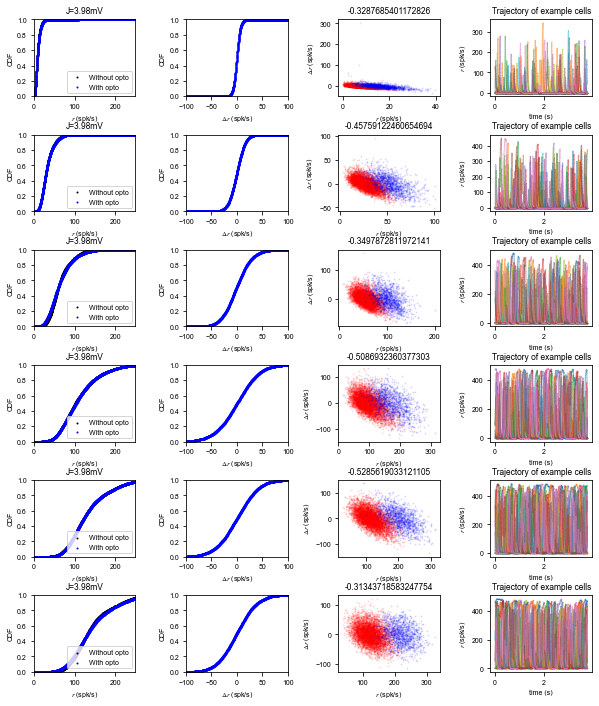

In [20]:
bin_edges=np.arange(0,1./tau_rp,.1)
spacings=np.diff(bin_edges)[0];
bin_means=0.5*(bin_edges[0:-1]+bin_edges[1::])
bin_edges_Delta=np.arange(-1./tau_rp,1./tau_rp,.1)
spacings_Delta=np.diff(bin_edges)[0];
bin_means_Delta=0.5*(bin_edges_Delta[0:-1]+bin_edges_Delta[1::])

fig, axs = plt.subplots(len(r_X),4, figsize=(2.5*4,2.0*len(r_X)), facecolor='w', edgecolor='k')#,sharey='row')#,sharex=True)
fig.subplots_adjust(hspace = .5, wspace=.5)
area=1.0;linethicknes=1.0;
axs = axs.ravel()
font = {'family' : 'normal','weight' : 'normal','size'   : 7, 'family':'serif','serif':['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] =linethicknes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42

idx_r_X=0
mask_active_cells=(RATES[idx_r_X,1,:]>=0)|(RATES[idx_r_X,0,:]>=0)
for idx_r_X in np.arange(1,len(r_X),1):
    mask_active_cells=mask_active_cells|(RATES[idx_r_X,1,:]>=0)|(RATES[idx_r_X,0,:]>=0)

for idx_r_X in range(len(r_X)):
    

    color=['k','b',];
    label=['Without opto','With opto']
    for idx_L in range(len(L)):
        #hist, bin_edges=np.histogram(RATES[idx_r_X,idx_L,0:N_E],bin_edges)#,normed=True)
        hist, bin_edges=np.histogram(RATES[idx_r_X,idx_L,mask_active_cells],bin_edges)#,normed=True)
        bin_mean=0.5*(bin_edges[0:-1]+bin_edges[1::])
        spacings=np.diff(bin_edges)[0];
        hist=hist/np.sum(hist*spacings)
        axs[idx_r_X*4+0].scatter(bin_mean,np.cumsum(spacings*hist),c=color[idx_L],s=area,label=label[idx_L])

        
    Delta_Sim=RATES[idx_r_X,1,mask_active_cells]-RATES[idx_r_X,0,mask_active_cells]
    print(len(Delta_Sim[Delta_Sim<0])/len(Delta_Sim))
    
    hist_Delta, bin_edges_Delta=np.histogram(Delta_Sim,bin_edges_Delta,normed=True)
    CDF_Resp_Delta=np.cumsum(hist_Delta*spacings_Delta)
    axs[idx_r_X*4+1].scatter(bin_means_Delta,CDF_Resp_Delta,c='b',s=area);


    #axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,maks_cells],RATES[idx_r_X,1,maks_cells]-RATES[idx_r_X,0,maks_cells],c='b',s=1,alpha=0.3);
    idx_cells=np.where(np.arange(len(Lambda_i))<N_E)
    axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,idx_cells],RATES[idx_r_X,1,idx_cells]-RATES[idx_r_X,0,idx_cells],c='r',s=1,alpha=0.1);
    idx_cells=np.where(np.arange(len(Lambda_i))>N_E)
    axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,idx_cells],RATES[idx_r_X,1,idx_cells]-RATES[idx_r_X,0,idx_cells],c='b',s=1,alpha=0.1);

    cov=np.cov(RATES[idx_r_X,0,mask_active_cells],RATES[idx_r_X,1,mask_active_cells]-RATES[idx_r_X,0,mask_active_cells])
    axs[idx_r_X*4+2].set_title(cov[0,1]/cov[1,1])


    for idx_cell in range(17):
        axs[idx_r_X*4+3].plot(T[mask_time]-T[mask_time][0],DYNA[idx_r_X,1,idx_cell,mask_time],marker='o',markersize=0.1,alpha=0.5)

    axs[idx_r_X*4+0].axis([0,250,.0,1.])
    axs[idx_r_X*4+0].legend(loc='lower right')
    axs[idx_r_X*4+1].axis([-100,100,0,1.])
    axs[idx_r_X*4+0].set_title('J=%.2fmV'%(J*10**3))
    axs[idx_r_X*4+0].set_ylabel('CDF')
    axs[idx_r_X*4+1].set_ylabel('CDF')
    axs[idx_r_X*4+0].set_xlabel('$r$ (spk/s)')
    axs[idx_r_X*4+1].set_xlabel('$\Delta r$ (spk/s)')
    axs[idx_r_X*4+2].set_ylabel('$\Delta r$ (spk/s)')
    axs[idx_r_X*4+2].set_xlabel('$r$ (spk/s)')
    axs[idx_r_X*4+3].set_ylabel('$r$ (spk/s)')
    axs[idx_r_X*4+3].set_xlabel('time (s)')
    axs[idx_r_X*4+3].set_title('Trajectory of example cells')

